In [8]:
from Transformer import BrainAgeTransformer, train_epoch, eval_epoch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch.load('vbm_features_aft_combat.pt')
VBM_train_features = data['train']
VBM_val_features = data['val']

df = pd.read_csv("val_participants.tsv", sep="\t")
val_ages = df['age'].values
df["Sex_numeric"] = df["sex"].map({"male": 0, "female": 1})


df2 = pd.read_csv("train_participants.tsv", sep="\t")
train_ages = df2['age'].values
df2["Sex_numeric"] = df2["sex"].map({"male": 0, "female": 1})

train_ages = train_ages.astype(np.float32)
val_ages = val_ages.astype(np.float32)

sex_train = torch.tensor(df2["Sex_numeric"].values, dtype=torch.float32).unsqueeze(1)
sex_val   = torch.tensor(df["Sex_numeric"].values, dtype=torch.float32).unsqueeze(1)

VBM_train_features_with_sex = torch.cat([VBM_train_features, sex_train], dim=1)
VBM_val_features_with_sex   = torch.cat([VBM_val_features, sex_val], dim=1)

# train_ds = TensorDataset(
#     VBM_train_features_with_sex.float(),
#     torch.from_numpy(train_ages)
# )
# val_ds = TensorDataset(
#     VBM_val_features_with_sex.float(),
#     torch.from_numpy(val_ages)
# )


train_ds = TensorDataset(
    VBM_train_features.float(),
    torch.from_numpy(train_ages)
)
val_ds = TensorDataset(
    VBM_val_features.float(),
    torch.from_numpy(val_ages)
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)

In [9]:
X = VBM_train_features.numpy()
y = train_ages

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def crossval_score(nhead, d_model, num_layers, lr=1e-3, epochs=10):
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        # split into train/val for this fold
        X_train, X_val = torch.tensor(X[train_idx]).float(), torch.tensor(X[val_idx]).float()
        y_train, y_val = torch.tensor(y[train_idx]).float(), torch.tensor(y[val_idx]).float()

        # datasets + loaders
        train_ds = TensorDataset(X_train, y_train)
        val_ds = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=64)

        # define model
        model = BrainAgeTransformer(n_features=X.shape[1],
                                    d_model=d_model,
                                    nhead=nhead,
                                    num_layers=num_layers).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # training loop (short)
        for _ in range(epochs):
            train_epoch(model, train_loader, opt, loss_fn, device)

        # validation
        val_mse = eval_epoch(model, val_loader, device)
        val_scores.append(val_mse)

    return np.mean(val_scores)

In [10]:
search_space = [
    {"d_model": 64, "nhead": 4, "num_layers": 2},
    {"d_model": 128, "nhead": 4, "num_layers": 2},
    {"d_model": 64, "nhead": 8, "num_layers": 3},
]

results = []
for params in search_space:
    avg_mse = crossval_score(**params, epochs=10)
    print(f"{params} → Val MSE: {avg_mse:.4f}")
    results.append((params, avg_mse))

# choose best
best_params, best_score = sorted(results, key=lambda x: x[1])[0]
print("\nBest config:", best_params, "→", best_score)

{'d_model': 64, 'nhead': 4, 'num_layers': 2} → Val MSE: 211.9506
{'d_model': 128, 'nhead': 4, 'num_layers': 2} → Val MSE: 214.1932
{'d_model': 64, 'nhead': 8, 'num_layers': 3} → Val MSE: 213.5635

Best config: {'d_model': 64, 'nhead': 4, 'num_layers': 2} → 211.95055450207275


In [11]:
n_features = 128
model = BrainAgeTransformer(n_features=n_features, 
                            d_model=best_params['d_model'],
                            nhead=best_params['nhead'],
                            num_layers=best_params['num_layers'] ).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 100

train_losses = []
val_losses = []

best_val = float('inf')
patience = 10
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, opt, loss_fn, device)
    val_loss = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} - Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}, RMSE: {val_loss**0.5:.2f}")

    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 01 - Train MSE: 543.5944, Val MSE: 308.1467, RMSE: 17.55
Epoch 02 - Train MSE: 304.2660, Val MSE: 173.7750, RMSE: 13.18
Epoch 03 - Train MSE: 221.1408, Val MSE: 163.4252, RMSE: 12.78
Epoch 04 - Train MSE: 213.7779, Val MSE: 162.8830, RMSE: 12.76
Epoch 05 - Train MSE: 213.5977, Val MSE: 166.9191, RMSE: 12.92
Epoch 06 - Train MSE: 213.9268, Val MSE: 165.9469, RMSE: 12.88
Epoch 07 - Train MSE: 211.5420, Val MSE: 154.7586, RMSE: 12.44
Epoch 08 - Train MSE: 205.2070, Val MSE: 152.5855, RMSE: 12.35
Epoch 09 - Train MSE: 202.8909, Val MSE: 157.2282, RMSE: 12.54
Epoch 10 - Train MSE: 198.1248, Val MSE: 149.7395, RMSE: 12.24
Epoch 11 - Train MSE: 195.8021, Val MSE: 153.7890, RMSE: 12.40
Epoch 12 - Train MSE: 196.4250, Val MSE: 170.0640, RMSE: 13.04
Epoch 13 - Train MSE: 196.9710, Val MSE: 148.6140, RMSE: 12.19
Epoch 14 - Train MSE: 192.0005, Val MSE: 157.2520, RMSE: 12.54
Epoch 15 - Train MSE: 194.7049, Val MSE: 167.1912, RMSE: 12.93
Epoch 16 - Train MSE: 190.4737, Val MSE: 166.1511, RMSE

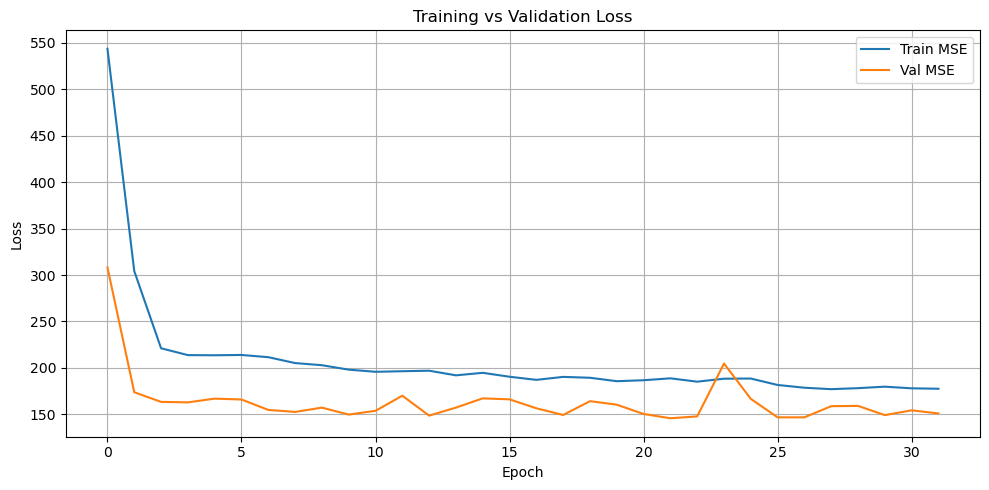

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_aft_combat.png")
plt.show()

In [13]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for feats, ages in val_loader:
        feats, ages = feats.to(device), ages.to(device)
        outputs = model(feats)
        y_true.extend(ages.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

# Create DataFrame
df_results = pd.DataFrame({
    "True_Age": y_true,
    "Predicted_Age": y_pred
})

print(df_results.head())


   True_Age  Predicted_Age
0     27.00      26.554153
1     37.00      40.222347
2     25.34      26.113308
3     26.00      32.844589
4     21.00      22.438898


In [14]:
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 8.70


In [7]:
df_results_sorted = df_results.sort_values(by="True_Age").reset_index(drop=True)
print(df_results_sorted.head())

   True_Age  Predicted_Age
0     5.900      23.584948
1     5.907      24.444366
2     6.000      23.583641
3     6.363      23.732168
4     6.470      24.037298


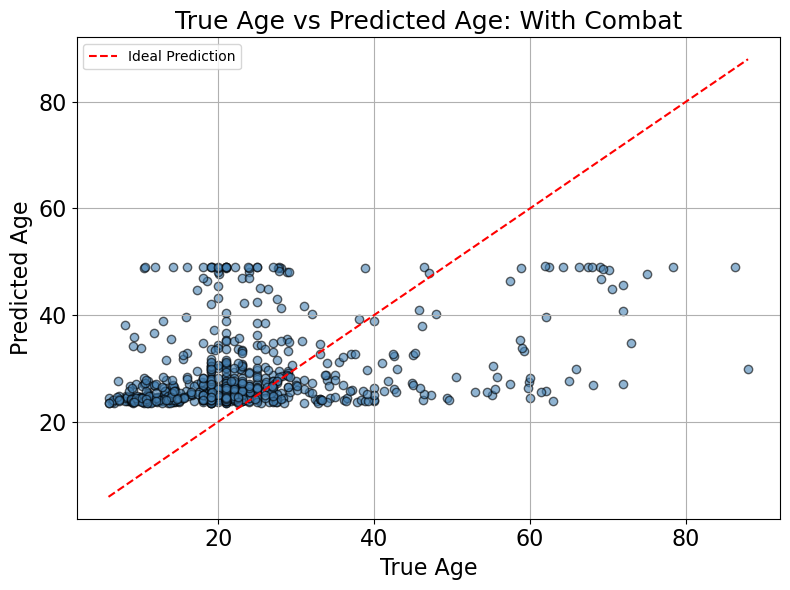

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(df_results["True_Age"], df_results["Predicted_Age"], alpha=0.6, color="steelblue", edgecolors='k')
plt.plot([df_results["True_Age"].min(), df_results["True_Age"].max()],
         [df_results["True_Age"].min(), df_results["True_Age"].max()],
         color='red', linestyle='--', label='Ideal Prediction')

plt.xlabel("True Age", fontsize=16)
plt.ylabel("Predicted Age", fontsize=16)

# Set tick label sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legend with larger font size
plt.legend(fontsize=16)
plt.title("True Age vs Predicted Age: With Combat", fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()